In [1]:
import torch
import os, sys
import numpy as np
module_rootdir = '../../..'
dataset_rootdir = '../../../..'
label_rootdir = module_rootdir
weight_rootdir = module_rootdir
sys.path.append(module_rootdir)

from modules.first_stage.inference import inference_gt_coord_with_nms
from modules.first_stage.set_parameters_for_inference import set_param_for_inference
from modules.first_stage.generate_gt import gen_training_gt
from modules.plot.viz_annotation import vizualize_bbox_resized

In [2]:
weights_file = 'model_weights/1705990924432/anchor_free_detector.pt'

param_dict = set_param_for_inference(
    dataset_type = 'kitti',
    module_rootdir = module_rootdir,
    dataset_rootdir = dataset_rootdir,
    label_rootdir = label_rootdir,
    batch_size = 1,
    trained_weights_file = os.path.join(weight_rootdir, weights_file))

device = param_dict['device']
dataset_param = param_dict['dataset_param']
dataset_train = param_dict['dataset_train']
dataset_val = param_dict['dataset_val'] 
detector = param_dict['detector']

deltas_mean = torch.tensor(dataset_param.deltas_mean, dtype=torch.float32, device=device)
deltas_std = torch.tensor(dataset_param.deltas_std, dtype=torch.float32, device=device)
grid_coord = dataset_param.grid_coord.to(device)

GPU is available. Good to go!
printing model config parameters
----------------------------------------------------------------------------------------------------
backbone                        : efficientnet_b4
num_backbone_nodes              : 4
num_extra_blocks                : 1
num_levels                      : 5
extra_blocks_feat_dim           : 512
num_fpn_blocks                  : 2
fpn_feat_dim                    : 128
prediction head stem_channels   : [128, 128, 128, 128]
activation                      : swish
image dimension BDD (H, W, D)   : (360, 640, 3)
image dimension KITTI (H, W, D) : (263, 873, 3)
num_classes                     : 2
DEVICE                          : cuda
****************************************************************************************************
 
Loading JSON file .. please wait
Sequence: 0000
Sequence: 0001
Sequence: 0002
Sequence: 0003
Sequence: 0004
Sequence: 0005
Sequence: 0006
Sequence: 0008
Sequence: 0009
Sequence: 0011
Sequence: 0012

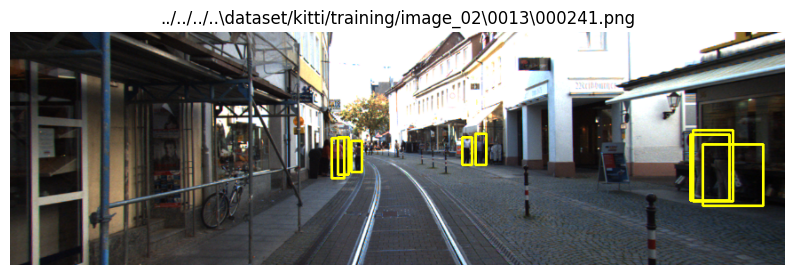

objectness scores in ascending order:
[0.12191187 0.1781913  0.5132177  0.62558764 0.76709574 0.7936653
 0.7976537  0.83126444]
class scores in ascending order:
[0.5128017  0.68129355 0.9986677  0.99960035 0.99988043 0.9999076
 0.9999136  0.99993074]


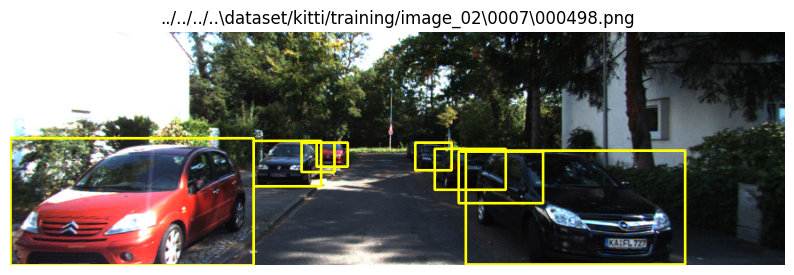

objectness scores in ascending order:
[0.27580774 0.64835906 0.7539987  0.9055821  0.9449642  0.9450272
 0.9481916  0.953737  ]
class scores in ascending order:
[0.99956256 0.9997104  0.9997725  0.9998017  0.9998085  0.99981874
 0.9998784  0.9999541 ]


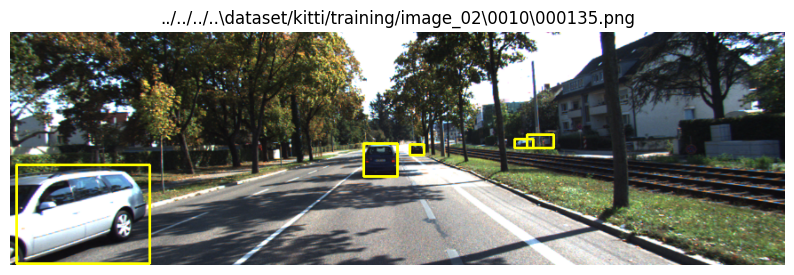

objectness scores in ascending order:
[0.34645495 0.4980865  0.76103216 0.95481604 0.968637  ]
class scores in ascending order:
[0.99904066 0.999858   0.99989724 0.9999635  0.9999949 ]


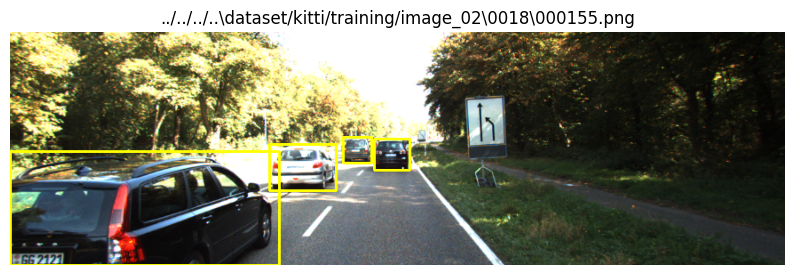

objectness scores in ascending order:
[0.9343499  0.9566868  0.95762634 0.96015614]
class scores in ascending order:
[0.9996184  0.999783   0.99979633 0.9999372 ]


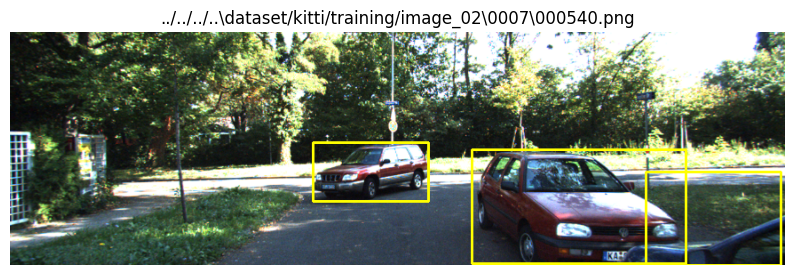

objectness scores in ascending order:
[0.6864172 0.9514687 0.9576011]
class scores in ascending order:
[0.99971884 0.99988616 0.99990094]


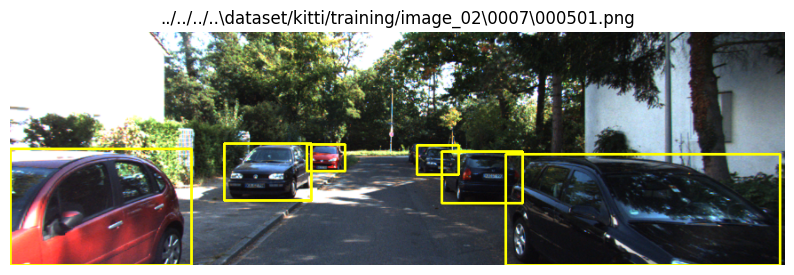

objectness scores in ascending order:
[0.84802073 0.9173532  0.9383647  0.94339895 0.9527489  0.9549838 ]
class scores in ascending order:
[0.99955326 0.9996012  0.9998252  0.99983764 0.9999143  0.99992526]


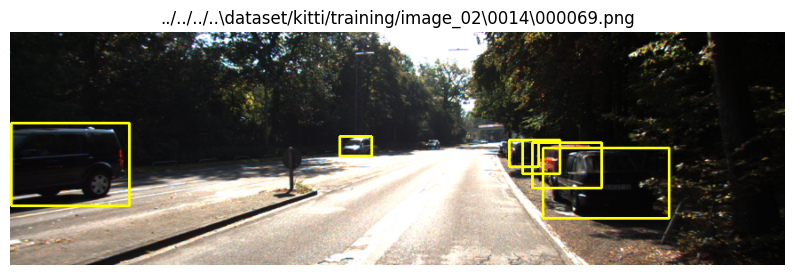

objectness scores in ascending order:
[0.42945194 0.81603074 0.9064047  0.93286467 0.9513799  0.95368814]
class scores in ascending order:
[0.99969566 0.99985886 0.99988115 0.9998915  0.99992394 0.99996066]


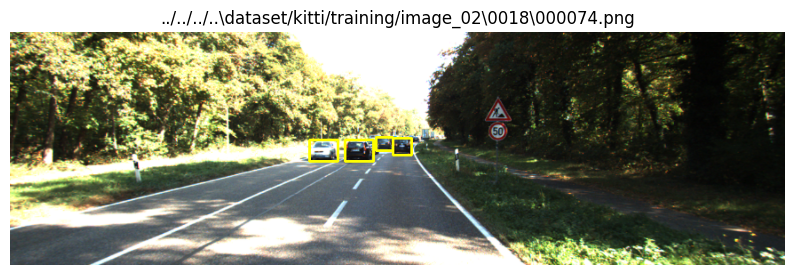

objectness scores in ascending order:
[0.885057  0.8985669 0.9148883 0.9363131]
class scores in ascending order:
[0.99991727 0.99995196 0.99995613 0.9999833 ]


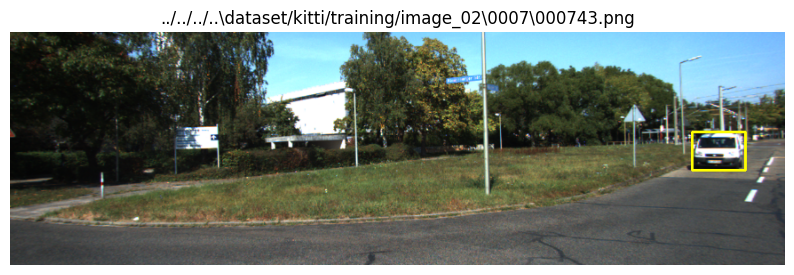

objectness scores in ascending order:
[0.9467226]
class scores in ascending order:
[0.9998777]


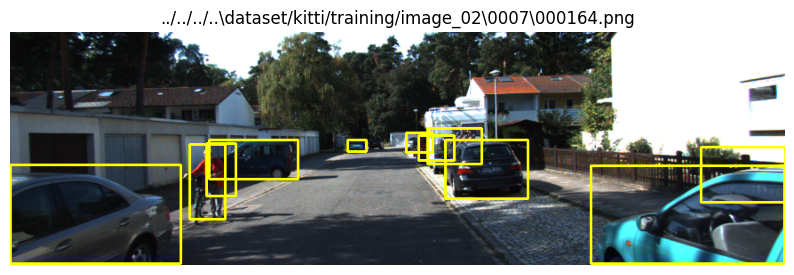

objectness scores in ascending order:
[0.13689636 0.2743361  0.29023728 0.3375603  0.54736555 0.7705093
 0.8872528  0.94963795 0.95402765 0.9541027  0.9571923 ]
class scores in ascending order:
[0.78645724 0.9813998  0.9962081  0.99706596 0.99861133 0.99966276
 0.9996842  0.9998084  0.9998104  0.9999068  0.9999503 ]


In [3]:
# dataset = dataset_train
dataset = dataset_val
iter_start_offset = 0
max_iters = iter_start_offset + 10

nms_thresh = 0.35

for iter in range(iter_start_offset, max_iters):

    img, labels = dataset.__getitem__(iter)
    img_path = labels['img_path']
    img = img.unsqueeze(0).to(device)
    bboxes = [labels['bbox'].to(device)]
    clslabels = [labels['obj_class_label'].to(device)]

    groundtruths = gen_training_gt(
        bboxes, 
        clslabels, 
        dataset_param.STRIDE_W,
        dataset_param.STRIDE_H,
        grid_coord,
        deltas_mean,
        deltas_std,
        device,
        dataset_param.ignored_classId)
    
    pred = inference_gt_coord_with_nms(
        detector, img, 
        grid_coord,
        deltas_mean, deltas_std,
        nms_thresh,
        groundtruths.objness_logits[0])
    
    obj_score = pred['pred_score'].cpu().numpy()
    pred_boxes = pred['pred_boxes'].cpu().numpy()
    cls_score = pred['cls_score'].cpu().numpy()
    cls_idx = pred['cls_idx'].cpu().numpy()

    vizualize_bbox_resized(img_path, pred_boxes, dataset_param.IMG_RESIZED_W, dataset_param.IMG_RESIZED_H, 
                           thickness = 2, figsize=(10,8))
    print('objectness scores in ascending order:')
    print(np.sort(obj_score))
    print('class scores in ascending order:')
    print(np.sort(cls_score))
    print('=' * 100)